In [1]:
import numpy as np 
import pandas as pd 
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [2]:
df2 = pd.read_excel(r"C:\Users\madam\Desktop\2805 RF Dataset.xlsx")
df2.head(5)

,SB,HB,BD,TB,Pf(kg/m3),XB(m),E(GPa),X50(m)
0,1.198974,1.366301,27.254728,0.736923,0.495592,0.576549,59.946268,0.341959
1,1.145491,1.303856,27.294058,0.762451,0.455873,0.612741,60.002893,0.386073
2,1.242155,1.317184,27.248093,0.896496,0.501227,0.994937,60.042361,0.358173
3,1.277583,1.316653,27.302029,0.727691,0.439071,1.093234,60.066082,0.453862
4,1.283793,1.359817,27.324111,0.812233,0.494853,1.122299,59.986148,0.525007


In [3]:
X = df2.drop(columns=['X50(m)'])
y = df2['X50(m)']
X.shape, y.shape

((2805, 7), (2805,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((2103, 7), (702, 7))

In [5]:
from mealpy import FloatVar, StringVar, IntegerVar, BoolVar, MixedSetVar, PSO, GWO, GOA, Problem
from mealpy.utils.visualize import *
from mealpy.utils import io

In [6]:
def objective_function(params):
    params = params.reshape(-1)
    params_dict = {
        'loss': 'poisson',
        'max_iter': int(params[0]),
        'max_depth': int(params[1]),
        'min_samples_leaf': int(params[2]),
        'max_bins': int(params[3]),
        'learning_rate': params[4],
        'max_leaf_nodes': int(params[5])
    }
    hgb = HistGradientBoostingRegressor(**params_dict, random_state=42)
    #cv = KFold(n_splits=5)
    #cv_score  = cross_val_score(hgb, X_train, y_train, cv=cv, scoring='r2')
    hgb.fit(X_train, y_train)
    y_pred =  hgb.predict(X_test)
    
    return r2_score(y_test, y_pred)

In [7]:
bounds = [(10, 100), # Lower and upper bounds for max_iter (0)
          (2, 20), # Lower and upper bounds for max_depth (1)
          (2, 30),  # Lower and upper bounds for min_samples_leaf (2)
          (10, 255),  # Lower and upper bounds for max_bins (3)
          (0.0001, 1.0), # Lower and upper bounds for learning_rate (4)
          (2, 50), # Lower and upper bounds for max_leaf_nodes (5)
         ]

# Define the problem dictionary for the optimizer
problem_dict = {
    "bounds": FloatVar(lb=np.array([bound[0] for bound in bounds]), ub=np.array([bound[1] for bound in bounds]), name="delta"),
    "obj_func": objective_function,
    "minmax": "max", # Minimize fitness (negative F1_Score)
}

In [8]:
model = GOA.OriginalGOA(epoch=100, pop_size=80, c_min=0.00004, c_max=1.0)
g_best = model.solve(problem_dict)

2024/10/10 10:18:57 AM, INFO, mealpy.swarm_based.GOA.OriginalGOA: Solving single objective optimization problem.
2024/10/10 10:19:11 AM, INFO, mealpy.swarm_based.GOA.OriginalGOA: >>>Problem: P, Epoch: 1, Current best: 0.8495903885147092, Global best: 0.8495903885147092, Runtime: 6.28115 seconds
2024/10/10 10:19:24 AM, INFO, mealpy.swarm_based.GOA.OriginalGOA: >>>Problem: P, Epoch: 2, Current best: 0.851165672220634, Global best: 0.851165672220634, Runtime: 12.34846 seconds
2024/10/10 10:19:33 AM, INFO, mealpy.swarm_based.GOA.OriginalGOA: >>>Problem: P, Epoch: 3, Current best: 0.8531521893240815, Global best: 0.8531521893240815, Runtime: 9.11275 seconds
2024/10/10 10:19:42 AM, INFO, mealpy.swarm_based.GOA.OriginalGOA: >>>Problem: P, Epoch: 4, Current best: 0.8548336473512747, Global best: 0.8548336473512747, Runtime: 9.38133 seconds
2024/10/10 10:19:53 AM, INFO, mealpy.swarm_based.GOA.OriginalGOA: >>>Problem: P, Epoch: 5, Current best: 0.8550007426283993, Global best: 0.8550007426283993

In [9]:
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")

Solution: [8.55463337e+01 1.37485946e+01 1.24636206e+01 1.12434724e+02
 6.83379967e-02 2.58499754e+01], Fitness: 0.8567868469906019


In [10]:
best_max_iter = int(g_best.solution[0])
best_max_depth = int(g_best.solution[1])
best_min_samples_leaf = int(g_best.solution[2])
best_max_bins = int(g_best.solution[3])
best_learning_rate = g_best.solution[4]
best_max_leaf_nodes = int(g_best.solution[5])


print(f"best_max_iter = {best_max_iter}")
print(f"best_max_depth = {best_max_depth}")
print(f"best_min_samples_leaf = {best_min_samples_leaf}")
print(f"best_max_bins = {best_max_bins}")
print(f"best_learning_rate = {best_learning_rate}")
print(f"best_max_leaf_nodes = {best_max_leaf_nodes}")

best_max_iter = 85
best_max_depth = 13
best_min_samples_leaf = 12
best_max_bins = 112
best_learning_rate = 0.0683379967109545
best_max_leaf_nodes = 25


In [13]:
best_params = {
    'loss': 'poisson',
    'max_iter': int(model.g_best.solution[0]),
    'max_depth': int(model.g_best.solution[1]),
    'min_samples_leaf': int(model.g_best.solution[2]),
    'max_bins': int(model.g_best.solution[3]),
    'learning_rate': model.g_best.solution[4],
    'max_leaf_nodes': int(model.g_best.solution[5]),
    
}

best_hgb = HistGradientBoostingRegressor(**best_params, random_state=42)
cv = KFold(n_splits=5, shuffle=True)
score = cross_val_score(best_hgb, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
best_hgb.fit(X_train, y_train)

HistGradientBoostingRegressor(learning_rate=np.float64(0.0683379967109545),
                              loss='poisson', max_bins=112, max_depth=13,
                              max_iter=85, max_leaf_nodes=25,
                              min_samples_leaf=12, random_state=42)

In [14]:
y_pred = best_hgb.predict(X_test)

In [15]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared=False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))

RMSE: 0.05939065070161336
MSE: 0.0035272493907610473
R2: 0.8567868469906019
MAE: 0.04523200690676642
MAPE: 0.21997093865658235
Explained Variance Score: 0.8572546099574294


d:\projects\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
y_pred2 = best_hgb.predict(X_train)

In [17]:
print('RMSE:',mean_squared_error(y_train, y_pred2, squared=False))
print('MSE:',mean_squared_error(y_train, y_pred2))
print('R2:', r2_score(y_train, y_pred2))
print('MAE:',mean_absolute_error(y_train, y_pred2))
print('MAPE:',mean_absolute_percentage_error(y_train, y_pred2))
print('Explained Variance Score:',explained_variance_score(y_train, y_pred2))

RMSE: 0.052112618732788656
MSE: 0.0027157250311889954
R2: 0.9003958797601433
MAE: 0.0401638098336805
MAPE: 0.20108927598431156
Explained Variance Score: 0.9003958973951695


d:\projects\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
import shap

shap.initjs()

d:\projects\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


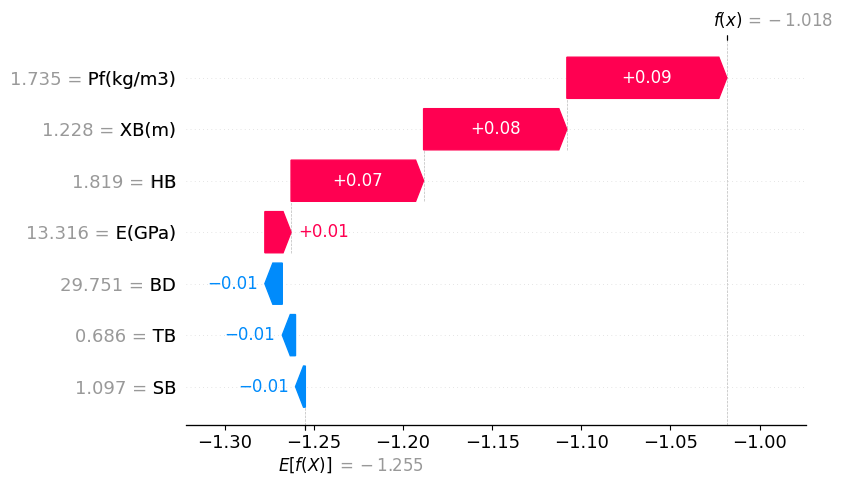

In [19]:
explainer = shap.Explainer(best_hgb)
shap_values = explainer(X_test)

shap.waterfall_plot(shap_values[0])

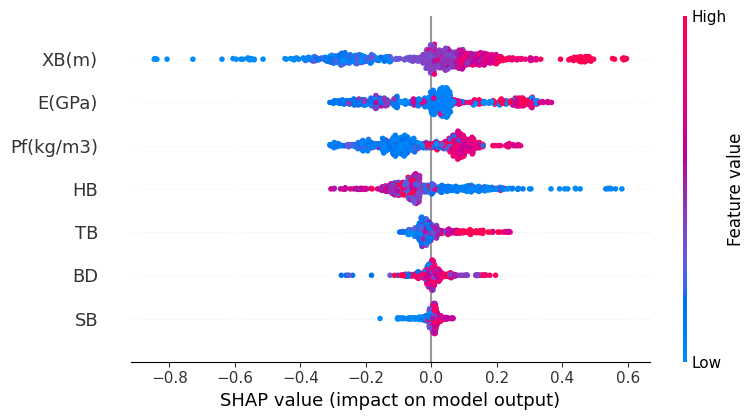

In [20]:
shap.summary_plot(shap_values, X_test)

In [24]:
# shap.dependence_plot('E(GPa)', shap_values, X_test)

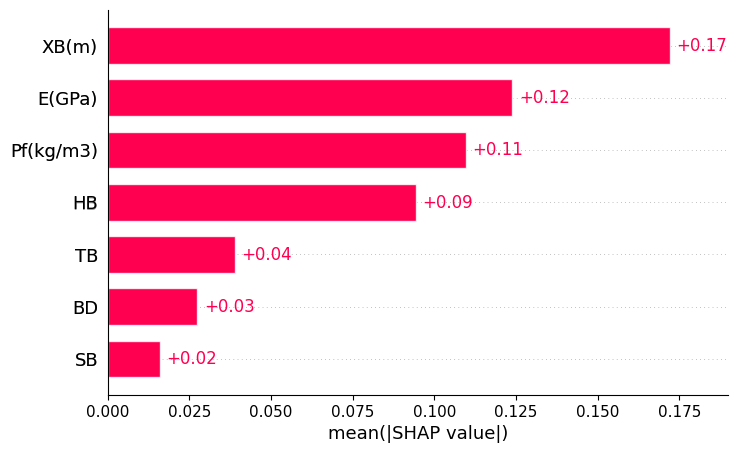

In [22]:
shap.plots.bar(shap_values)

In [25]:
import pickle
filename = 'HGB-model.pkl'
pickle.dump(best_hgb, open(filename, 'wb'))